In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from hydra import initialize, compose
from hydra.utils import get_class, instantiate
from omegaconf import OmegaConf

In [2]:
with initialize(version_base=None, config_path="config/conf"):
    cfg = compose(config_name="config.yaml", overrides=["dataset.batch_size=64", "early_stopper=null", "+experiment=E28"])
print(OmegaConf.to_yaml(cfg))

dataset:
  img_size: 299
  num_workers: 10
  batch_size: 64
  shuffle_train: true
  _target_: datasets.shapes_dataset.JointDataModule
  annotation_path: /home/danis/Projects/AlphaCaption/AutoConceptBottleneck/data/shapes-hard-nonrobust/captions.csv
  collate_fn:
    _target_: datasets.collators.CollateIndices
    vocabulary:
      _target_: datasets.utils.VocabularyShapes
      annotation_path: /home/danis/Projects/AlphaCaption/AutoConceptBottleneck/data/shapes-hard-nonrobust/captions.csv
model:
  _target_: models.auto_concept_bottleneck.LitAutoConceptBottleneckModel
  main:
    _target_: models.auto_concept_bottleneck.AutoConceptBottleneckModel
    feature_extractor:
      _target_: models.feature_extractors.torchvision.TorchvisionFeatureExtractor
      model: inception_v3
      weights: IMAGENET1K_V1
      out_features: 10
    concept_extractor:
      _target_: models.concept_extractors.novel.ConceptExtractorAttention
      vocab_size: 55
      embed_dim: 8
      out_features: 10
   

In [3]:
dm = instantiate(cfg.dataset)
dm.setup()
train_loader = dm.train_dataloader()
train_set = train_loader.dataset

[nltk_data] Downloading package wordnet to /home/danis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
100%|██████████| 2700/2700 [00:00<00:00, 9618.08it/s]


Len of vocab:  54
Max len of caption:  16
Index for <pad>: [0]


In [4]:
checkpoint_path = "/home/danis/Projects/AlphaCaption/AutoConceptBottleneck/autoconcept/outputs/2023-05-03/06-01-10/lightning_logs/version_0/checkpoints/epoch008-val_loss1.89118.ckpt"
target_class = get_class(cfg.model._target_)
main = instantiate(cfg.model.main)
model = target_class.load_from_checkpoint(
    checkpoint_path, main=main).cuda()

/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'criterion_task' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion_task'])`.
  rank_zero_warn(
/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'criterion_tie' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion_tie'])`.
  rank_zero_warn(


In [5]:
train_set[1403]

{'image': tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],
 
         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044,

In [6]:
model = model.eval()

In [7]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function

import os
import json

In [8]:
sample = train_set[1403]
image = sample['image'].cuda()

In [16]:
def model_proxy(x):
    return nn.Softmax(dim=-1)(model.main.inference(x)['prediction'])

In [17]:
model_proxy(image.unsqueeze(0))

tensor([[0.0077, 0.0094, 0.1658, 0.0717, 0.0082, 0.0250, 0.6108, 0.0269, 0.0746]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [18]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [19]:
integrated_gradients = IntegratedGradients(model_proxy)
attributions_ig = integrated_gradients.attribute(image.unsqueeze(0), target=0, n_steps=30)

In [20]:
attributions_ig = attributions_ig.squeeze().cpu().detach().numpy()

In [21]:
attributions_ig.min(), attributions_ig.max()

(-0.0032031395128135427, 0.003403073191239646)

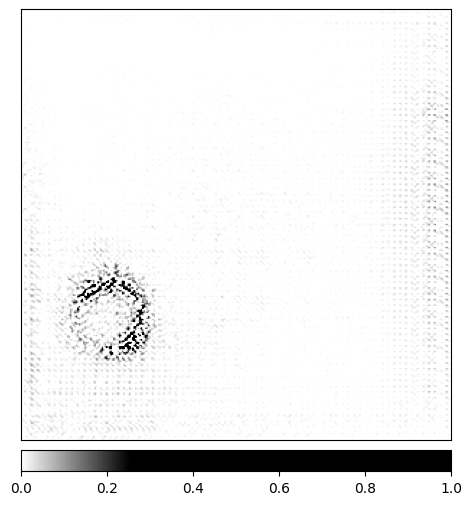

In [22]:
from matplotlib.colors import LinearSegmentedColormap
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig, (1,2,0)),
                             np.transpose(image.unsqueeze(0).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


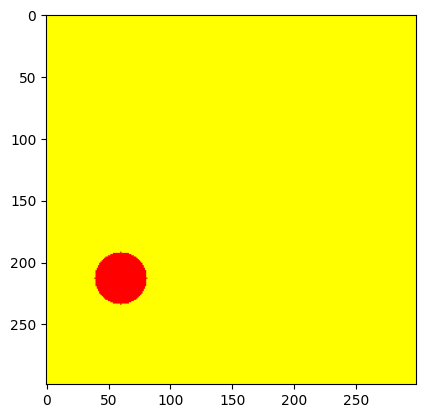

In [23]:
img = image.cpu().detach().numpy()

img = img.transpose((1, 2, 0))

plt.imshow(img)